In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
import os
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if len(gpus) > 0:
    print("TensorFlow is using the following GPU(s):")
    for gpu in gpus:
        print(f"- {gpu.name}")
else:
    print("No GPUs detected. TensorFlow is running on CPU.")

TensorFlow is using the following GPU(s):
- /physical_device:GPU:0


In [3]:
def load_file(board_file, labels_file):
    with open(board_file, 'r') as f:
        board = []
        for line in f:
            row = []
            for cell in line.strip().split(" "):
                if cell == '-':
                    row.append(0)
                elif cell == 'F':
                    row.append(1)
                else:
                    try:
                        row.append(int(cell) + 2)
                    except ValueError:
                        continue
            board.append(row)

    board = np.array(board)

    labels = []
    with open(labels_file, 'r') as f:
        for line in f:
            row = []
            for cell in line.strip().split(" "):
                row.append(int(cell))
            labels.append(row)

    labels = np.array(labels)
    return board, labels

def create_dataset(data_dir, labels_dir):
    data_files = sorted(os.listdir(data_dir))
    label_files = sorted(os.listdir(labels_dir))

    if len(data_files) != len(label_files):
        raise ValueError("The number of data files does not match the number of label files.")
    
    def generator():
        for data_file, label_file in zip(data_files, label_files):
            board, labels = load_file(os.path.join(data_dir, data_file), os.path.join(labels_dir, label_file))
            yield board, labels
    
    with open(os.path.join(data_dir, data_files[0]), 'r') as f:
        lines = f.readlines()
        num_rows = len(lines)
        num_cols = len(lines[0].split()) if num_rows > 0 else 0

    dataset = tf.data.Dataset.from_generator(generator, output_signature=(
        tf.TensorSpec(shape=(num_rows, num_cols), dtype=tf.int32),
        tf.TensorSpec(shape=(num_rows, num_cols), dtype=tf.int32))
    )

    return dataset, (num_cols, num_rows)



data_dir = "data 8x8"
labels_dir = "labels 8x8"
dataset, input_shape = create_dataset(data_dir, labels_dir)


In [4]:
dataset_list = list(dataset)

train_size = int(0.7 * len(dataset_list))
val_size = int(0.2 * len(dataset_list))
test_size = len(dataset_list) - train_size - val_size

train_data = dataset_list[:train_size]
val_data = dataset_list[train_size:train_size + val_size]
test_data = dataset_list[train_size + val_size:]

train = tf.data.Dataset.from_generator(lambda: iter(train_data), output_signature=(
    tf.TensorSpec(shape=input_shape, dtype=tf.int32), tf.TensorSpec(shape=input_shape, dtype=tf.int32)))
val = tf.data.Dataset.from_generator(lambda: iter(val_data), output_signature=(
    tf.TensorSpec(shape=input_shape, dtype=tf.int32), tf.TensorSpec(shape=input_shape, dtype=tf.int32)))
test = tf.data.Dataset.from_generator(lambda: iter(test_data), output_signature=(
    tf.TensorSpec(shape=input_shape, dtype=tf.int32), tf.TensorSpec(shape=input_shape, dtype=tf.int32)))

train = train.batch(64)
val = val.batch(64)
test = test.batch(64)

In [ ]:
model = Sequential()

model.add(Flatten(input_shape=input_shape))

model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))

model.add(Dense(input_shape[0] * input_shape[1], activation='sigmoid'))

model.add(Reshape((input_shape[0], input_shape[1])))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# model.summary()

In [16]:
hist = model.fit(train, epochs=10, validation_data=val, batch_size=64)

Epoch 1/10


766/766 [==============================] - 6s 7ms/step - loss: 0.2954 - binary_accuracy: 0.8813 - val_loss: 0.2651 - val_binary_accuracy: 0.8943
Epoch 2/10
766/766 [==============================] - 6s 7ms/step - loss: 0.2564 - binary_accuracy: 0.8988 - val_loss: 0.2549 - val_binary_accuracy: 0.8998
Epoch 3/10
766/766 [==============================] - 5s 7ms/step - loss: 0.2469 - binary_accuracy: 0.9033 - val_loss: 0.2491 - val_binary_accuracy: 0.9027
Epoch 4/10
766/766 [==============================] - 5s 7ms/step - loss: 0.2406 - binary_accuracy: 0.9060 - val_loss: 0.2463 - val_binary_accuracy: 0.9039
Epoch 5/10
766/766 [==============================] - 5s 7ms/step - loss: 0.2357 - binary_accuracy: 0.9081 - val_loss: 0.2444 - val_binary_accuracy: 0.9049
Epoch 6/10
766/766 [==============================] - 5s 7ms/step - loss: 0.2317 - binary_accuracy: 0.9098 - val_loss: 0.2428 - val_binary_accuracy: 0.9057
Epoch 7/10
766/766 [==============================] - 5s 6ms/step - loss: 0

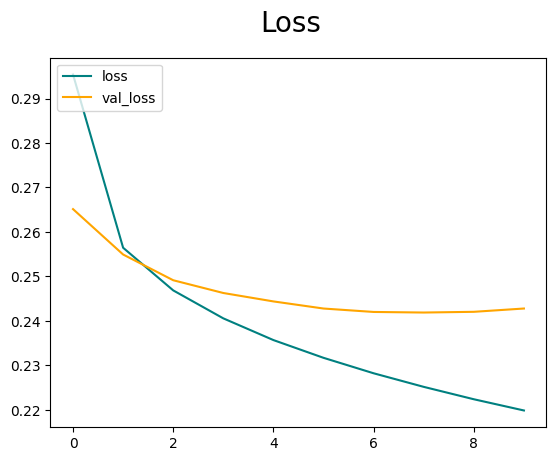

In [17]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)    
plt.legend(loc="upper left")
plt.show()

In [18]:
total_mines = 0
correctly_predicted_mines = 0

for boards, labels in test:
    predictions = model.predict(boards)
    predicted_classes = (predictions > 0.5).astype(int)

    for i in range(boards.shape[0]):
        actual_mines = (labels[i] == 1)
        predicted_mines = (predicted_classes[i] == 1)

        total_mines += np.sum(actual_mines)
        correctly_predicted_mines += np.sum(np.logical_and(actual_mines, predicted_mines))

print(f"Total number of actual mines: {total_mines}")
print(f"Number of correctly predicted mines: {correctly_predicted_mines}")
accuracy = (correctly_predicted_mines / total_mines) * 100 if total_mines > 0 else 0
print(f"Accuracy in predicting mines: {accuracy:.2f}%")

1/1 [==============================] - 0s 33ms/step
Total number of actual mines: 70000
Number of correctly predicted mines: 37510
Accuracy in predicting mines: 53.59%


1/1 [==============================] - 0s 11ms/step
Coordinates with highest mine probability: (6, 3)
Highest mine probability: 0.9891409873962402


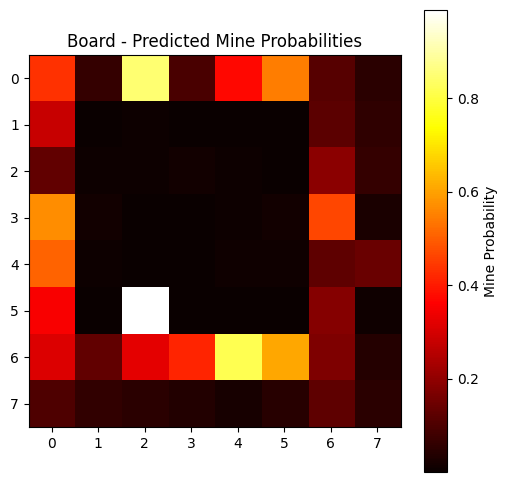

Input Board:
U U U U U U U U
U 1 1 2 1 1 U U
U 1 0 0 0 1 U U
U 1 0 0 0 1 U U
U 3 1 1 0 1 U U
U 3 -1 3 2 2 U U
U U U U U U U U
U U U U U U U U

Labels:
1 0 1 0 0 1 0 1
0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0
1 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0
1 0 0 0 1 0 1 0
0 0 0 0 0 0 0 0


In [19]:
def test_model_on_board(model, board):
    board = np.expand_dims(board, axis=0)
    
    prediction = model.predict(board)
    predicted_probabilities = prediction[0]
    
    max_cord = (0, 0)
    max_prediction = 0
    for row, predicted_row in enumerate(predicted_probabilities):
        for col, predicted_cell in enumerate(predicted_row):
            if predicted_cell > max_prediction:
                max_prediction = predicted_cell
                max_cord = (row + 1, col + 1)
    
    print(f"Coordinates with highest mine probability: {max_cord}")
    print(f"Highest mine probability: {max_prediction}")
    
    plt.figure(figsize=(6, 6))
    plt.title(f"Board - Predicted Mine Probabilities")
    plt.imshow(predicted_probabilities, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Mine Probability')
    plt.show()

def map_cell_value(cell):
    if cell == 0:
        return 'U'
    elif cell == 1:
        return -1
    else:
        return cell - 2

def print_board(board, map=True):
    if map:
        board = np.vectorize(map_cell_value)(board)
    for row in board:
        print(" ".join(str(cell) for cell in row))

for board, labels in dataset.take(1):
    board_np = board.numpy()
    labels_np = labels.numpy()

    test_model_on_board(model, board_np)
    
    print("Input Board:")
    print_board(board_np)
    
    print("\nLabels:")
    print_board(labels_np, map=False)